In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import ast
from wordcloud import WordCloud
from collections import Counter

## Data

In [2]:
# Original CSV dataset
# --------------------------------------------------------------------------------
data = pd.read_csv("../Resources/data/tmdb_data.csv")

# Aditional Features
# --------------------------------------------------------------------------------
data = pd.merge(data, pd.read_csv('../Resources/data/tmdb_AdditionalFeatures.csv'), how='left', on=['imdb_id'])

print(data.shape)

(3000, 26)


Note: Pandas dataframe.skew() function returns unbiased skew over requested axis Normalized by N-1. Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

In [3]:
# Apply the pandas `.skew()` function to find skewness of the dataframe. 
# --------------------------------------------------------------------------------
pd.DataFrame(data.skew().sort_values(ascending=False)).head(10)

,0
popularity,14.377407
revenue,4.542285
totalVotes,4.189146
budget,3.103530
popularity2,1.952750
runtime,1.017619
id,0.000000
rating,-0.489699


## Data Exploration and Cleaning

In [4]:
# 
# --------------------------------------------------------------------------------
data_explore = data.copy()

In [5]:
# 
# --------------------------------------------------------------------------------
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [6]:
# 
# --------------------------------------------------------------------------------
data_explore.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
popularity2               118
rating                    118
totalVotes                118
dtype: int64

In [7]:
# 
# --------------------------------------------------------------------------------
data_explore['sequel'] = data_explore['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1).astype('int64')

In [8]:
# Function to extract the year, month and day on which the movie was release. Date format is mm/dd/YY.
# --------------------------------------------------------------------------------
def modify_date(x):
    x=str(x)
    year=x.split('/')[2]
    if int(year)<20:
        return x[:-2]+'20'+year
    else:
        return x[:-2]+'19'+year
    
data_explore['release_date']=data_explore['release_date'].apply(lambda x: modify_date(x))
data_explore['release_year'] = pd.DatetimeIndex(data_explore['release_date']).year
data_explore['release_month'] = pd.DatetimeIndex(data_explore['release_date']).month
data_explore['release_day'] = pd.DatetimeIndex(data_explore['release_date']).day
data_explore['release_dayofweek'] = pd.DatetimeIndex(data_explore['release_date']).dayofweek

In [9]:
# 
# --------------------------------------------------------------------------------
nan_cols = data_explore.isna().sum()
nan_cols[nan_cols>0]

belongs_to_collection    2396
genres                      7
homepage                 2054
overview                    8
poster_path                 1
production_companies      156
production_countries       55
runtime                     2
spoken_languages           20
tagline                   597
Keywords                  276
cast                       13
crew                       16
popularity2               118
rating                    118
totalVotes                118
dtype: int64

In [10]:
# 
# --------------------------------------------------------------------------------
data_explore.describe()

,id,budget,popularity,runtime,revenue,popularity2,rating,totalVotes,sequel,release_year,release_month,release_day,release_dayofweek
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03,2882.000000,2882.000000,2882.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07,8.029303,6.366308,933.938584,0.201333,1999.713000,6.775333,15.046333,3.269333
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08,4.959153,0.887465,1795.101380,0.401063,15.423313,3.409115,8.632981,1.306150
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00,0.600000,1.000000,1.000000,0.000000,1921.000000,1.000000,1.000000,0.000000
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06,5.046250,5.800000,82.000000,0.000000,1993.000000,4.000000,8.000000,2.000000
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07,7.503500,6.400000,292.500000,0.000000,2004.000000,7.000000,15.000000,4.000000
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07,9.987000,7.000000,900.500000,0.000000,2011.000000,10.000000,22.000000,4.000000
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09,45.153000,9.000000,18931.000000,1.000000,2017.000000,12.000000,31.000000,6.000000


In [11]:
# 
# --------------------------------------------------------------------------------
import ast
dict_cols = ['genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

for col in dict_cols:
    data_explore[col] = data_explore[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

In [12]:
# 
# --------------------------------------------------------------------------------
na_cols = data_explore.columns[data_explore.isna().any()].tolist()
na_cols.remove('overview')
na_cols.remove('runtime')
na_cols.remove('popularity2')
na_cols.remove('rating')
na_cols.remove('totalVotes')
data_explore['runtime'].fillna(value=data_explore['runtime'].median(), inplace=True)
data_explore['overview'].fillna(value='', inplace=True)
data_explore['popularity2'].fillna(value=0, inplace=True)
data_explore['rating'].fillna(value=0, inplace=True)
data_explore['totalVotes'].fillna(value=0, inplace=True)
for col in na_cols:
    data_explore[col].fillna(value='', inplace=True)

## Top Keywords in Movies

In [13]:
# 
# --------------------------------------------------------------------------------
for i, e in enumerate(data_explore['Keywords'][:2]):
    print(i,e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]


In [14]:
# 
# --------------------------------------------------------------------------------
list_keywords = list(data_explore['Keywords'].apply(lambda x: [i['name'] for i in x] if x!= {} else []))
Counter(i for j in list_keywords for i in j).most_common(10)

[('woman director', 175),
 ('independent film', 155),
 ('duringcreditsstinger', 134),
 ('murder', 123),
 ('based on novel', 111),
 ('violence', 87),
 ('sport', 82),
 ('biography', 77),
 ('aftercreditsstinger', 75),
 ('dystopia', 73)]

In [15]:
# 
# --------------------------------------------------------------------------------
top_keywords = [m[0] for m in Counter(i for j in list_keywords for i in j).most_common(10)]
data_explore['num_of_keywords'] = data_explore['Keywords'].apply(lambda x: len(x) if x!={} else 0)

data_explore['all_keywords'] = data_explore['Keywords'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                               if x!= {} else '')
for k in top_keywords:
    data_explore['keyword_'+ k] = data_explore['all_keywords'].apply(lambda x: 1 if k in x else 0)

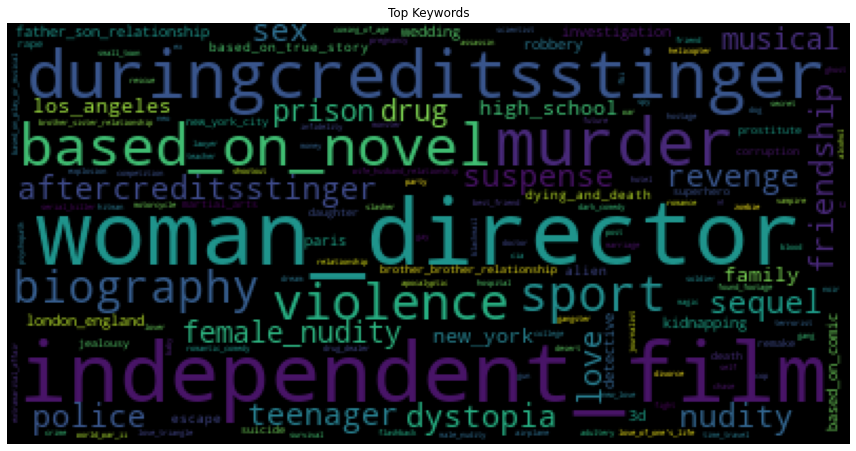

In [68]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12,10))
text3 = ' '.join(['_'.join(i.split(' ')) for j in list_keywords for i in j])
wordcloud3 = WordCloud(collocations = False).generate(text3)
plt.imshow(wordcloud3)
plt.title('Top Keywords')
plt.axis('off')
# plt.show()

# Save and Show plot
plt.tight_layout()
plt.savefig("../Images/wordCloud_Keywords.png")
plt.show()

## Most Common Spoken Languages released for Movies

In [17]:
# 
# --------------------------------------------------------------------------------
for i, e in enumerate(data_explore['spoken_languages'][:2]):
    print(i,e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]


In [18]:
# 
# --------------------------------------------------------------------------------
print('Number of Languages Movies released in:')
data_explore['spoken_languages'].apply(lambda x: len(x) if x!={} else 0).value_counts()

Number of Languages Movies released in:


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [19]:
# 
# --------------------------------------------------------------------------------
list_of_language = list(data_explore['spoken_languages'].apply(lambda x: [i['name'] for i in x]
                                                    if x!= {} else []))
top_language = [m[0] for m in Counter(i for j in list_of_language for i in j).most_common(5)]
Counter(i for j in list_of_language for i in j).most_common(5)

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152)]

In [20]:
# 
# --------------------------------------------------------------------------------
data_explore['num_of_languages'] = data_explore['spoken_languages'].apply(lambda x: len(x) if x!= {} else 0)

data_explore['all_languages'] = data_explore['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name']for i in x]))
                                                    if x!= {} else '')

for l in top_language:
    data_explore['language_' + l] = data_explore['all_languages'].apply(lambda x: 1 if l in x else 0)

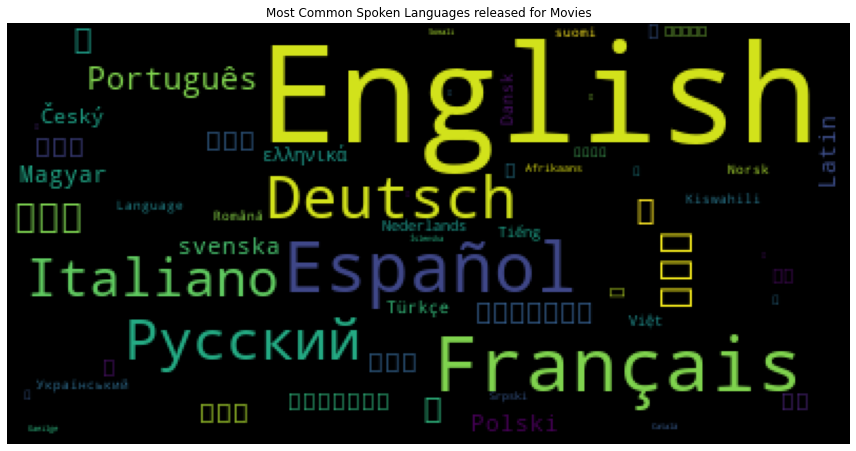

In [69]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12,8))
text2 = ' '.join(i for j in list_of_language for i in j)
wordcloud2 = WordCloud(collocations=False).generate(text2)
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Most Common Spoken Languages released for Movies')

# Save and Show plot
plt.tight_layout()
plt.savefig("../Images/wordCloud_Language.png")
plt.show()

## Director Gender

In [22]:
# 
# --------------------------------------------------------------------------------
gender_df = pd.DataFrame([data_explore.imdb_id, data_explore.crew]).transpose()
gender_df = gender_df.rename(columns={'crew': 'director_gender'})
gender_df.head()

,imdb_id,director_gender
0,tt2637294,"[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,tt0368933,"[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,tt2582802,"[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,tt1821480,"[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,tt1380152,"[{'credit_id': '52fe464b9251416c75073b43', 'de..."


In [23]:
# 
# --------------------------------------------------------------------------------
dict_columns = ['director_gender']
# for column in dict_columns:
#     gender_df[column] = gender_df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

In [24]:
# 
# --------------------------------------------------------------------------------
def get_gender(x, column):
    gender = []
    for item in x:
        if col=='director_gender':
            if item['job']=='Director' 'gender'==1:
                gender.append(item['gender'])
        elif col=='director_gender':
            if item['job']=='Director' 'gender'==2:
                gender.append(item['gender'])
        else:
            gender.append(item['gender'])
        return gender

In [25]:
# 
# --------------------------------------------------------------------------------
gender_df.head()

,imdb_id,director_gender
0,tt2637294,"[{'credit_id': '59ac067c92514107af02c8c8', 'de..."
1,tt0368933,"[{'credit_id': '52fe43fe9251416c7502563d', 'de..."
2,tt2582802,"[{'credit_id': '54d5356ec3a3683ba0000039', 'de..."
3,tt1821480,"[{'credit_id': '52fe48779251416c9108d6eb', 'de..."
4,tt1380152,"[{'credit_id': '52fe464b9251416c75073b43', 'de..."


In [26]:
# 
# --------------------------------------------------------------------------------
gender =[]
for item in gender_df['director_gender']:
    for j in item:
#         print(j)
        if j['job'] == 'Director':
            print(j['gender'],j['job'])
            gender.append(j['gender'])

2 Director
2 Director
2 Director
0 Director
0 Director
2 Director
2 Director
1 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
0 Director
2 Director
2 Director
2 Director
0 Director
2 Director
0 Director
1 Director
0 Director
2 Director
2 Director
0 Director
0 Director
0 Director
1 Director
0 Director
0 Director
2 Director
0 Director
0 Director
2 Director
1 Director
0 Director
0 Director
0 Director
2 Director
0 Director
0 Director
0 Director
0 Director
2 Director
0 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
1 Director
0 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director

1 Director
2 Director
1 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
1 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
1 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
0 Director
2 Director
2 Director
2 Director
0 Director
2 Director
0 Director
2 Director
0 Director
2 Director
0 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
1 Director
2 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
0 Director
2 Director
0 Director
1 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director

2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
1 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
1 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
0 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director
2 Director
0 Director
1 Director
2 Director
2 Director
0 Director
2 Director
2 Director
2 Director

## Director and Lead Cast Members

In [27]:
# Fetch the name field from each JSON object. Extract the Director from Crew only and extract first 3 main cast members from the cast field (main roles from movie)
# --------------------------------------------------------------------------------
def get_names(x, col):
    names = []
    for item in x:
        if col=='crew':
            if item['job']=='Director':
                names.append(item['name'])
        elif col=='cast':
            if item['order'] in (0, 1, 2):
                names.append(item['name'])
        else:
            names.append(item['name'])
    return names

    
for col in dict_cols:
    data_explore[col] = data_explore[col].apply(lambda x: get_names(x, col))

In [28]:
# 
# --------------------------------------------------------------------------------
data_explore.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,popularity2,rating,totalVotes,sequel,release_year,release_month,release_day,release_dayofweek,num_of_keywords,all_keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,num_of_languages,all_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,[Comedy],,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/2015,93.0,[English],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke]",[Steve Pink],12314651,10.400,5.0,482.0,1,2015,2,20,4,4,duringcreditsstinger hot tub sequel time travel,0,0,1,0,0,0,0,0,0,0,1,English,1,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[Comedy, Drama, Family, Romance]",,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/2004,113.0,[English],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizondo]",[Garry Marshall],95149435,15.229,6.4,1528.0,1,2004,8,6,4,4,coronation duty falling in love marriage,0,0,0,0,0,0,0,0,0,0,1,English,1,0,0,0,0


## Histogram

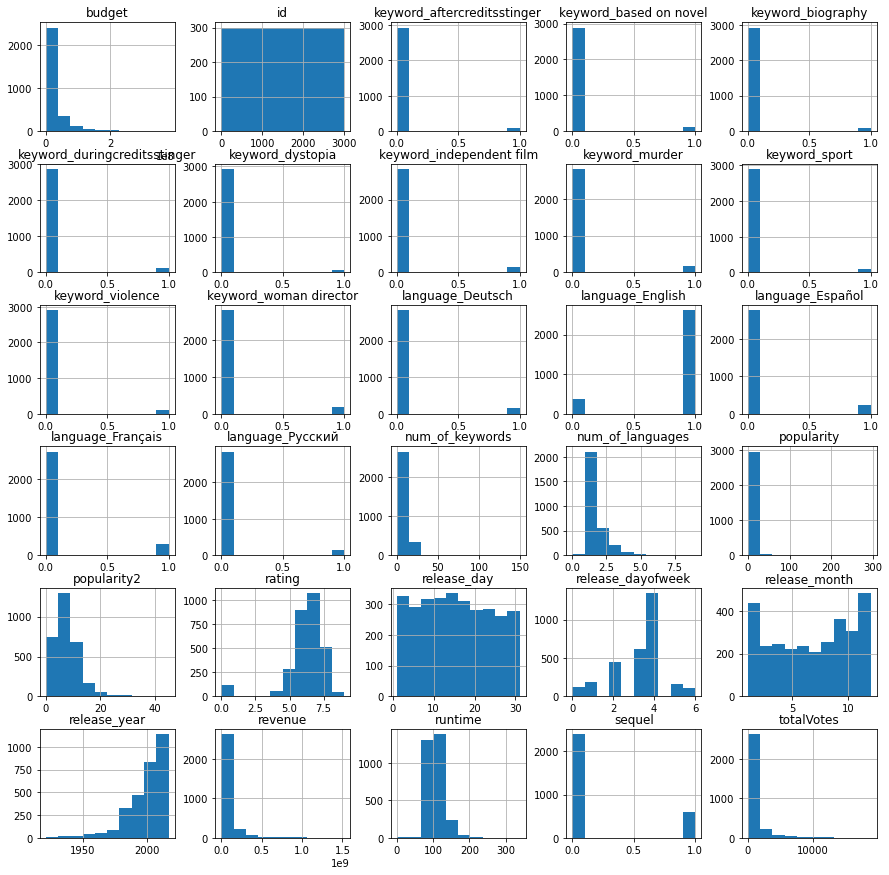

In [29]:
# 
# --------------------------------------------------------------------------------
data_explore.hist(figsize=(15, 15))
plt.show()

## Top 10 Most Popular Movies

In [30]:
# 
# --------------------------------------------------------------------------------
most_popular = data_explore.sort_values('popularity', ascending=False).head(10)
most_popular['revenue(million)'] = most_popular['revenue'].apply(lambda x : x//1000000)    # revenue in millions
most_popular['budget(million)'] = most_popular['budget'].apply(lambda x : x//1000000)    # budget in millions
most_popular[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
518,"[Action, Adventure, Fantasy]",Wonder Woman,"[Dune Entertainment, Atlas Entertainment, Warn...",294.337037,40.447,7.3,11614.0,[],[],149,820
684,"[Family, Fantasy, Romance]",Beauty and the Beast,"[Walt Disney Pictures, Mandeville Films]",287.253654,27.941,6.9,10470.0,"[Emma Watson, Dan Stevens, Luke Evans]",[Bill Condon],160,1262
1695,"[Action, Crime]",Baby Driver,"[Big Talk Productions, TriStar Pictures, Media...",228.032744,19.248,7.4,7325.0,"[Ansel Elgort, Lily James, Kevin Spacey]",[Edgar Wright],34,224
2326,"[Action, Adventure, Comedy]",Deadpool,"[Twentieth Century Fox Film Corporation, Marve...",187.860492,31.708,7.5,18931.0,"[Ryan Reynolds, Morena Baccarin, Ed Skrein]",[Tim Miller],58,783
2126,"[Action, Adventure, Comedy, Science Fiction]",Guardians of the Galaxy Vol. 2,"[Walt Disney Pictures, Marvel Studios]",185.330992,39.214,7.7,11217.0,"[Chris Pratt, Zoe Saldana, Dave Bautista]",[James Gunn],200,863
1309,"[Mystery, Thriller, Drama]",Gone Girl,"[Twentieth Century Fox Film Corporation, Regen...",154.801009,39.667,7.9,9623.0,"[Ben Affleck, Rosamund Pike, Carrie Coon]",[David Fincher],61,369
1715,"[Drama, Science Fiction, War]",War for the Planet of the Apes,[Chernin Entertainment],146.161786,29.360,7.0,4931.0,"[Andy Serkis, Woody Harrelson, Steve Zahn]",[Matt Reeves],152,369
1673,"[Drama, Action, Crime, Thriller]",The Dark Knight,"[DC Comics, Legendary Pictures, Warner Bros., ...",123.167259,31.350,8.4,17810.0,"[Christian Bale, Michael Caine, Heath Ledger]",[Christopher Nolan],185,1004
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,45.153,7.6,17988.0,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
2293,"[Drama, Thriller, Science Fiction]",The Circle,"[Likely Story, Playtone, Image Nation]",88.439243,11.626,5.5,2511.0,"[Emma Watson, Tom Hanks, John Boyega]",[James Ponsoldt],18,20


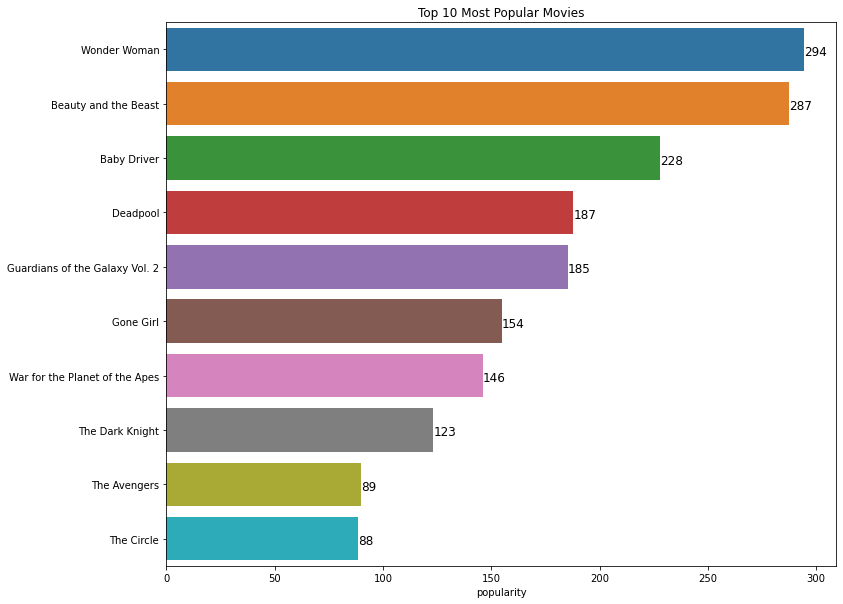

In [31]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='popularity', data=most_popular, order=most_popular.sort_values('popularity', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Most Popular Movies', fontsize=12)
plt.ylabel('')
plt.show()

In [32]:
# 
# --------------------------------------------------------------------------------
most_popular2 = data_explore.sort_values('popularity2', ascending=False).head(10)
most_popular2['revenue(million)'] = most_popular2['revenue'].apply(lambda x : x//1000000)    # revenue in millions
most_popular2['budget(million)'] = most_popular2['budget'].apply(lambda x : x//1000000)    # budget in millions
most_popular2[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,45.153,7.6,17988.0,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
114,"[Adventure, Fantasy, Action]",The Lord of the Rings: The Fellowship of the Ring,"[WingNut Films, New Line Cinema, The Saul Zaen...",32.070725,43.951,8.3,13552.0,"[Elijah Wood, Ian McKellen, Cate Blanchett]",[Peter Jackson],93,871
518,"[Action, Adventure, Fantasy]",Wonder Woman,"[Dune Entertainment, Atlas Entertainment, Warn...",294.337037,40.447,7.3,11614.0,[],[],149,820
2802,"[Adventure, Fantasy, Family]",Harry Potter and the Chamber of Secrets,"[1492 Pictures, Heyday films, Warner Bros.]",29.741452,40.269,7.7,10853.0,"[Daniel Radcliffe, Rupert Grint, Emma Watson]",[Chris Columbus],100,876
1309,"[Mystery, Thriller, Drama]",Gone Girl,"[Twentieth Century Fox Film Corporation, Regen...",154.801009,39.667,7.9,9623.0,"[Ben Affleck, Rosamund Pike, Carrie Coon]",[David Fincher],61,369
2126,"[Action, Adventure, Comedy, Science Fiction]",Guardians of the Galaxy Vol. 2,"[Walt Disney Pictures, Marvel Studios]",185.330992,39.214,7.7,11217.0,"[Chris Pratt, Zoe Saldana, Dave Bautista]",[James Gunn],200,863
286,"[Horror, Thriller]",Split,"[Universal Pictures, Blumhouse Productions, Bl...",28.920839,38.559,7.2,9418.0,"[James McAvoy, Anya Taylor-Joy, Betty Buckley]",[M. Night Shyamalan],9,276
2018,"[Action, Science Fiction, Adventure]",Guardians of the Galaxy,"[Marvel Studios, Moving Picture Company (MPC),...",53.291601,37.952,7.9,16508.0,"[Chris Pratt, Zoe Saldana, Dave Bautista]",[James Gunn],170,773
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,36.059,7.3,12057.0,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
1341,"[Drama, Romance]",The Vow,"[Spyglass Entertainment, Screen Gems]",9.524298,33.271,7.1,2241.0,"[Rachel McAdams, Channing Tatum, Sam Neill]",[Michael Sucsy],30,196


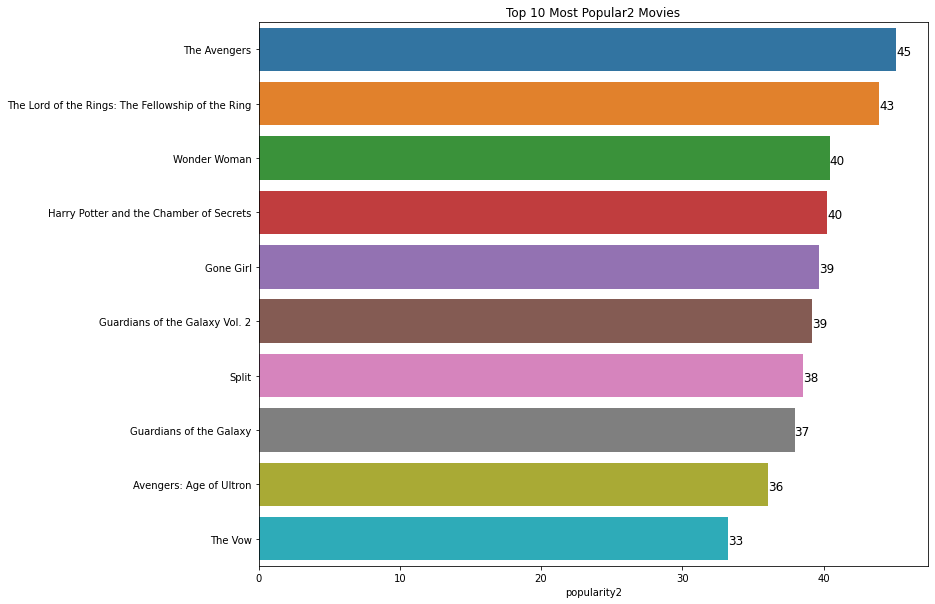

In [33]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='popularity2', data=most_popular2, order=most_popular2.sort_values('popularity2', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Most Popular2 Movies', fontsize=12)
plt.ylabel('')
plt.show()

## Top 10 Most Voted Movies

In [34]:
# 
# --------------------------------------------------------------------------------
most_votes = data_explore.sort_values('totalVotes', ascending=False).head(10)
most_votes['revenue(million)'] = most_votes['revenue'].apply(lambda x : x//1000000)    # revenue in millions
most_votes['budget(million)'] = most_votes['budget'].apply(lambda x : x//1000000)    # budget in millions
most_votes[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
2326,"[Action, Adventure, Comedy]",Deadpool,"[Twentieth Century Fox Film Corporation, Marve...",187.860492,31.708,7.5,18931.0,"[Ryan Reynolds, Morena Baccarin, Ed Skrein]",[Tim Miller],58,783
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,45.153,7.6,17988.0,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
1673,"[Drama, Action, Crime, Thriller]",The Dark Knight,"[DC Comics, Legendary Pictures, Warner Bros., ...",123.167259,31.350,8.4,17810.0,"[Christian Bale, Michael Caine, Heath Ledger]",[Christopher Nolan],185,1004
2018,"[Action, Science Fiction, Adventure]",Guardians of the Galaxy,"[Marvel Studios, Moving Picture Company (MPC),...",53.291601,37.952,7.9,16508.0,"[Chris Pratt, Zoe Saldana, Dave Bautista]",[James Gunn],170,773
2338,[Drama],Fight Club,"[Twentieth Century Fox Film Corporation, Regen...",63.869599,32.799,8.4,15256.0,"[Edward Norton, Brad Pitt, Meat Loaf]",[David Fincher],63,100
837,"[Action, Adventure, Science Fiction, Thriller]",Mad Max: Fury Road,"[Village Roadshow Pictures, Kennedy Miller Pro...",29.361780,24.647,7.4,13685.0,"[Tom Hardy, Charlize Theron, Nicholas Hoult]",[George Miller],150,378
114,"[Adventure, Fantasy, Action]",The Lord of the Rings: The Fellowship of the Ring,"[WingNut Films, New Line Cinema, The Saul Zaen...",32.070725,43.951,8.3,13552.0,"[Elijah Wood, Ian McKellen, Cate Blanchett]",[Peter Jackson],93,871
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,23.035,7.7,13165.0,[],[],250,1084
2016,"[Drama, Crime]",The Shawshank Redemption,"[Castle Rock Entertainment, Warner Bros.]",51.645403,30.102,8.6,12215.0,"[Tim Robbins, Morgan Freeman, Bob Gunton]",[Frank Darabont],25,28
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,36.059,7.3,12057.0,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405


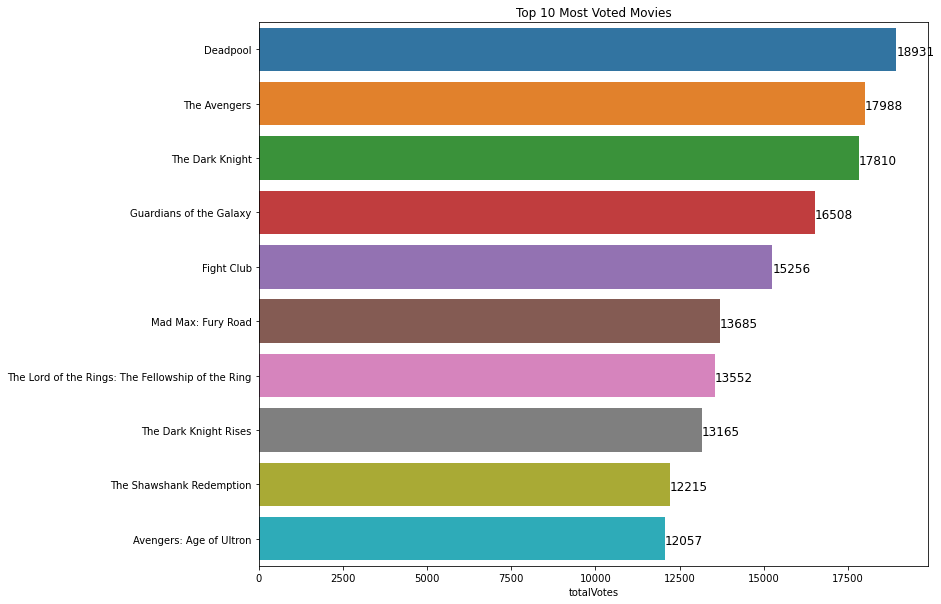

In [35]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='totalVotes', data=most_votes, order=most_votes.sort_values('totalVotes', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Most Voted Movies', fontsize=12)
plt.ylabel('')
plt.show()

## Top 10 Highest Rated Movies

In [36]:
# 
# --------------------------------------------------------------------------------
highest_rating = data_explore.sort_values('rating', ascending=False).head(10)
highest_rating['revenue(million)'] = highest_rating['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_rating['budget(million)'] = highest_rating['budget'].apply(lambda x : x//1000000)    # budget in millions
highest_rating[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
586,[Music],Katyar Kaljat Ghusali,[],0.446454,0.674,9.0,2.0,[Shankar Mahadevan],[Subodh Bhave],1,4
2946,"[Drama, Comedy, Romance]",My Best Girl,[Mary Pickford Company],0.205671,1.247,8.8,4.0,"[Mary Pickford, Charles 'Buddy' Rogers, Sunshi...",[Sam Taylor],0,1
2016,"[Drama, Crime]",The Shawshank Redemption,"[Castle Rock Entertainment, Warner Bros.]",51.645403,30.102,8.6,12215.0,"[Tim Robbins, Morgan Freeman, Bob Gunton]",[Frank Darabont],25,28
1093,"[Drama, Crime]",The Godfather,"[Paramount Pictures, Alfran Productions]",41.109264,24.786,8.6,9368.0,"[Marlon Brando, Al Pacino, James Caan]",[Francis Ford Coppola],6,245
2795,"[Drama, History]",The Visual Bible: The Gospel of John,"[Gospel of John Ltd., Toronto Film Studios, Vi...",1.551648,1.573,8.6,17.0,"[Christopher Plummer, Henry Ian Cusick, Stuart...",[Philip Saville],10,4
2721,"[Drama, Comedy]",There Goes My Baby,[Nelson Entertainment],0.377787,1.160,8.5,2.0,"[Dermot Mulroney, Ricky Schroder, Kelli Williams]",[Floyd Mutrux],10,0
2652,[Comedy],The Great Dictator,"[United Artists, Roy Export Company Establishm...",9.241748,10.793,8.4,1345.0,"[Charlie Chaplin, Jack Oakie, Reginald Gardiner]",[Charlie Chaplin],2,11
1673,"[Drama, Action, Crime, Thriller]",The Dark Knight,"[DC Comics, Legendary Pictures, Warner Bros., ...",123.167259,31.350,8.4,17810.0,"[Christian Bale, Michael Caine, Heath Ledger]",[Christopher Nolan],185,1004
2338,[Drama],Fight Club,"[Twentieth Century Fox Film Corporation, Regen...",63.869599,32.799,8.4,15256.0,"[Edward Norton, Brad Pitt, Meat Loaf]",[David Fincher],63,100
2765,"[Drama, Romance]",Cinema Paradiso,[Rai Tre Radiotelevisione Italiana],14.177005,10.515,8.4,1591.0,"[Philippe Noiret, Jacques Perrin, Marco Leonardi]",[Giuseppe Tornatore],0,11


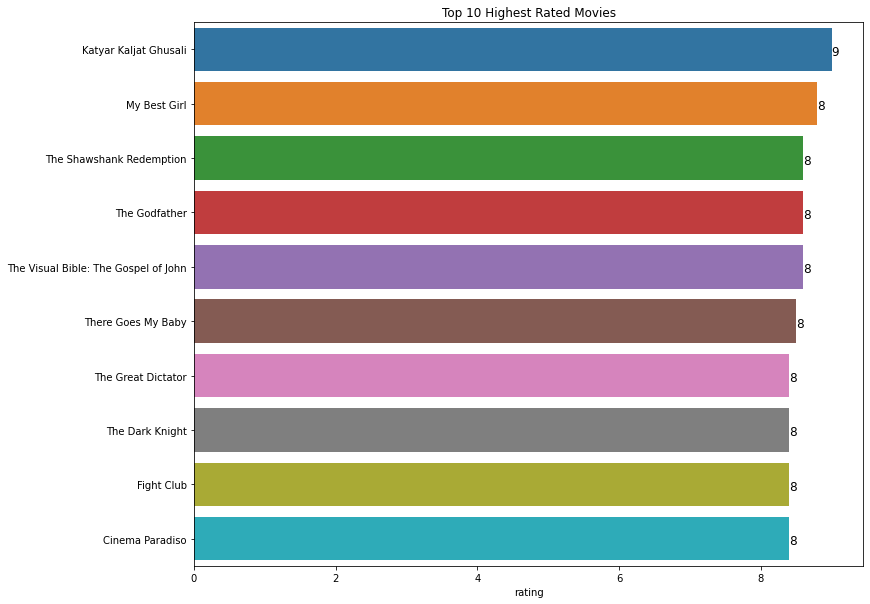

In [37]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='rating', data=highest_rating, order=highest_rating.sort_values('rating', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Highest Rated Movies', fontsize=12)
plt.ylabel('')
plt.show()

## Top 10 Highest Revenue Movies

In [38]:
# 
# --------------------------------------------------------------------------------
highest_revenue = data_explore.sort_values('revenue', ascending=False).head(10)
highest_revenue['revenue(million)'] = highest_revenue['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_revenue['budget(million)'] = highest_revenue['budget'].apply(lambda x : x//1000000)    # budget in millions
highest_revenue[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,45.153,7.6,17988.0,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
1761,[Action],Furious 7,"[Universal Pictures, Original Film, Fuji Telev...",27.275687,23.527,7.3,6178.0,"[Vin Diesel, Paul Walker, Dwayne Johnson]",[James Wan],190,1506
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,36.059,7.3,12057.0,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
684,"[Family, Fantasy, Romance]",Beauty and the Beast,"[Walt Disney Pictures, Mandeville Films]",287.253654,27.941,6.9,10470.0,"[Emma Watson, Dan Stevens, Luke Evans]",[Bill Condon],160,1262
2322,"[Action, Science Fiction, Adventure]",Transformers: Dark of the Moon,"[Paramount Pictures, Di Bonaventura Pictures, ...",4.503505,3.699,6.1,4682.0,"[Shia LaBeouf, John Malkovich, Ken Jeong]",[Michael Bay],195,1123
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,23.035,7.7,13165.0,[],[],250,1084
2135,"[Adventure, Action, Fantasy]",Pirates of the Caribbean: On Stranger Tides,"[Walt Disney Pictures, Jerry Bruckheimer Films...",27.887720,20.948,6.4,8040.0,"[Johnny Depp, Pen√©lope Cruz, Ian McShane]",[Rob Marshall],380,1045
2562,"[Adventure, Animation, Comedy, Family]",Finding Dory,"[Walt Disney Pictures, Pixar Animation Studios...",14.477677,15.535,7.0,7349.0,"[Ellen DeGeneres, Albert Brooks, Hayden Rolence]","[Andrew Stanton, Angus MacLane]",200,1028
881,"[Family, Fantasy, Adventure]",Alice in Wonderland,"[Walt Disney Pictures, Team Todd, Tim Burton P...",17.285093,17.123,6.5,8056.0,"[Mia Wasikowska, Johnny Depp, Anne Hathaway]",[Tim Burton],200,1025
734,"[Animation, Adventure, Family, Comedy]",Zootopia,"[Walt Disney Pictures, Walt Disney Animation S...",26.024868,31.637,7.7,9349.0,"[Ginnifer Goodwin, Jason Bateman, Shakira]","[Byron Howard, Rich Moore, Jared Bush]",150,1023


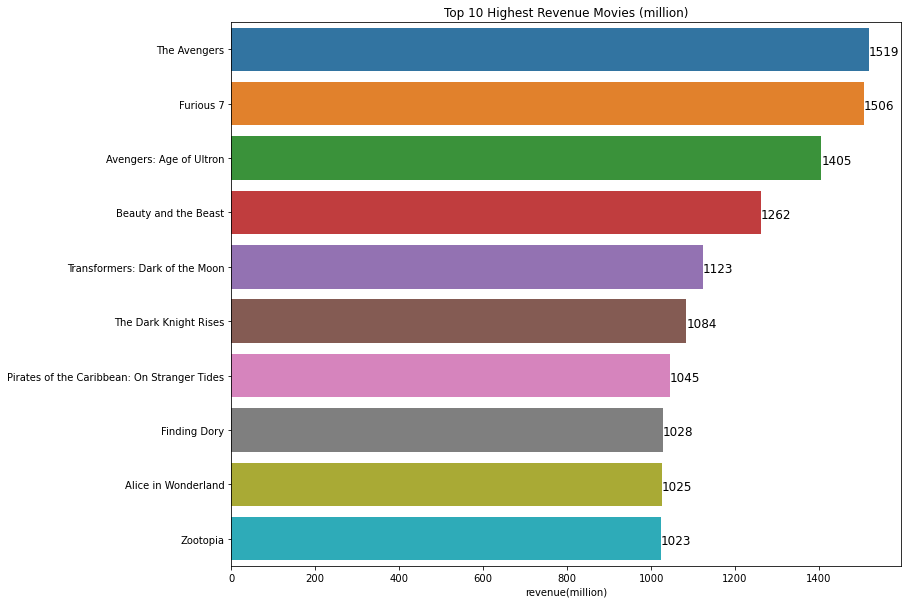

In [39]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='revenue(million)', data=highest_revenue, order=highest_revenue.sort_values('revenue(million)', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Highest Revenue Movies (million)', fontsize=12)
plt.ylabel('')
plt.show()

## Top 10 Highest Budgeted Movies

In [40]:
# 
# --------------------------------------------------------------------------------
highest_budget = data_explore.sort_values('budget', ascending=False).head(10)
highest_budget['revenue(million)'] = highest_budget['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_budget['budget(million)'] = highest_budget['budget'].apply(lambda x : x//1000000)    # budgest in millions
highest_budget[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
2135,"[Adventure, Action, Fantasy]",Pirates of the Caribbean: On Stranger Tides,"[Walt Disney Pictures, Jerry Bruckheimer Films...",27.887720,20.948,6.4,8040.0,"[Johnny Depp, Pen√©lope Cruz, Ian McShane]",[Rob Marshall],380,1045
2209,"[Adventure, Fantasy, Action]",Pirates of the Caribbean: At World's End,"[Walt Disney Pictures, Jerry Bruckheimer Films...",31.363664,23.290,7.1,7788.0,"[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski],300,961
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,36.059,7.3,12057.0,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
1425,"[Adventure, Fantasy, Action, Science Fiction]",Superman Returns,"[DC Comics, Legendary Pictures, Warner Bros., ...",13.284712,14.746,5.5,2194.0,"[Brandon Routh, Kevin Spacey, Kate Bosworth]",[Bryan Singer],270,391
1270,"[Action, Adventure, Science Fiction]",John Carter,[Walt Disney Pictures],14.670353,12.593,6.1,3132.0,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton],260,284
1630,"[Action, Science Fiction, Thriller, Adventure]",Transformers: The Last Knight,"[Paramount Pictures, Di Bonaventura Pictures, ...",39.186819,28.409,6.0,3026.0,"[Mark Wahlberg, Josh Duhamel, Laura Haddock]",[Michael Bay],260,604
2532,"[Adventure, Fantasy, Action]",The Hobbit: An Unexpected Journey,"[WingNut Films, New Line Cinema, Warner Bros. ...",23.253089,24.642,7.2,11498.0,"[Ian McKellen, Martin Freeman, Richard Armitage]",[Peter Jackson],250,1021
961,"[Adventure, Fantasy, Family]",Harry Potter and the Half-Blood Prince,"[Warner Bros., Heyday Films]",19.083723,29.714,7.6,9712.0,"[Daniel Radcliffe, Rupert Grint, Emma Watson]",[David Yates],250,933
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,23.035,7.7,13165.0,[],[],250,1084
666,"[Adventure, Fantasy]",The Hobbit: The Desolation of Smaug,"[WingNut Films, New Line Cinema, Warner Bros. ...",20.644776,18.718,7.6,7234.0,"[Martin Freeman, Ian McKellen, Richard Armitage]",[Peter Jackson],250,958


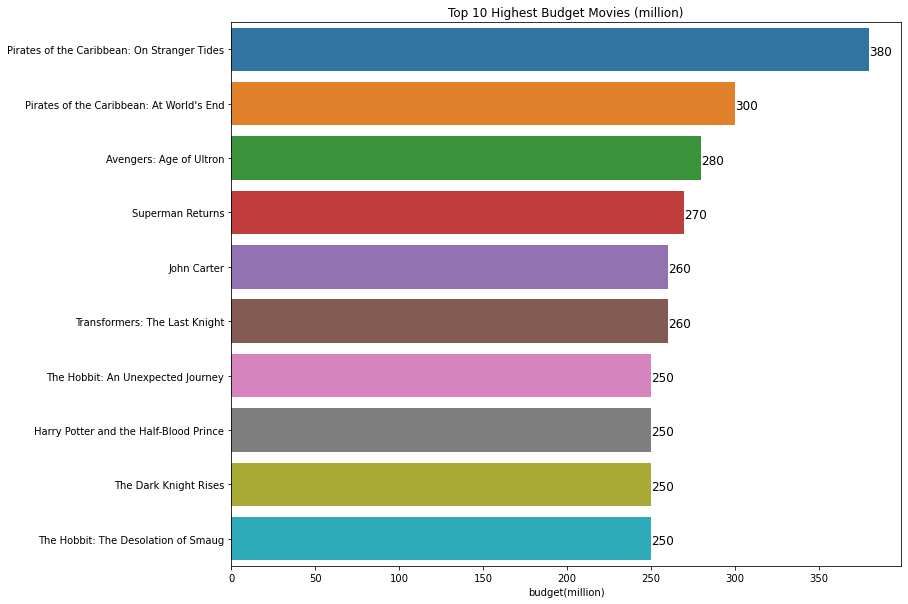

In [41]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='budget(million)', data=highest_budget, order=highest_budget.sort_values('budget(million)', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Highest Budget Movies (million)', fontsize=12)
plt.ylabel('')
plt.show()

## Top 10 Highest Gross Income Movies

In [42]:
# 
# --------------------------------------------------------------------------------
highest_profit = data_explore.copy()
highest_profit['revenue(million)'] = highest_profit['revenue'].apply(lambda x : x//1000000)    # revenue in millions
highest_profit['budget(million)'] = highest_profit['budget'].apply(lambda x : x//1000000)    # budget in millions
highest_profit['profit(million)'] = highest_profit['revenue(million)']-highest_profit['budget(million)']
highest_profit = highest_profit.sort_values('profit(million)', ascending=False).head(10)
highest_profit[['genres','title', 'production_companies','popularity', 'popularity2','rating','totalVotes', 'cast', 'crew', 'budget(million)', 'revenue(million)']]

,genres,title,production_companies,popularity,popularity2,rating,totalVotes,cast,crew,budget(million),revenue(million)
1761,[Action],Furious 7,"[Universal Pictures, Original Film, Fuji Telev...",27.275687,23.527,7.3,6178.0,"[Vin Diesel, Paul Walker, Dwayne Johnson]",[James Wan],190,1506
1126,"[Science Fiction, Action, Adventure]",The Avengers,"[Paramount Pictures, Marvel Studios]",89.887648,45.153,7.6,17988.0,"[Robert Downey Jr., Chris Evans, Mark Ruffalo]",[Joss Whedon],220,1519
2770,"[Action, Adventure, Science Fiction]",Avengers: Age of Ultron,"[Marvel Studios, Prime Focus, Revolution Sun S...",37.379420,36.059,7.3,12057.0,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",[Joss Whedon],280,1405
684,"[Family, Fantasy, Romance]",Beauty and the Beast,"[Walt Disney Pictures, Mandeville Films]",287.253654,27.941,6.9,10470.0,"[Emma Watson, Dan Stevens, Luke Evans]",[Bill Condon],160,1262
2322,"[Action, Science Fiction, Adventure]",Transformers: Dark of the Moon,"[Paramount Pictures, Di Bonaventura Pictures, ...",4.503505,3.699,6.1,4682.0,"[Shia LaBeouf, John Malkovich, Ken Jeong]",[Michael Bay],195,1123
734,"[Animation, Adventure, Family, Comedy]",Zootopia,"[Walt Disney Pictures, Walt Disney Animation S...",26.024868,31.637,7.7,9349.0,"[Ginnifer Goodwin, Jason Bateman, Shakira]","[Byron Howard, Rich Moore, Jared Bush]",150,1023
1735,"[Adventure, Science Fiction]",Jurassic Park,"[Universal Pictures, Amblin Entertainment]",8.863776,13.347,7.8,8295.0,"[Sam Neill, Laura Dern, Jeff Goldblum]",[Steven Spielberg],63,920
543,"[Adventure, Fantasy, Action]",The Lord of the Rings: The Two Towers,"[WingNut Films, New Line Cinema, The Saul Zaen...",29.423537,24.886,8.2,11696.0,"[Elijah Wood, Ian McKellen, Viggo Mortensen]",[Peter Jackson],79,926
906,"[Action, Crime, Drama, Thriller]",The Dark Knight Rises,"[Legendary Pictures, Warner Bros., DC Entertai...",20.582580,23.035,7.7,13165.0,[],[],250,1084
2562,"[Adventure, Animation, Comedy, Family]",Finding Dory,"[Walt Disney Pictures, Pixar Animation Studios...",14.477677,15.535,7.0,7349.0,"[Ellen DeGeneres, Albert Brooks, Hayden Rolence]","[Andrew Stanton, Angus MacLane]",200,1028


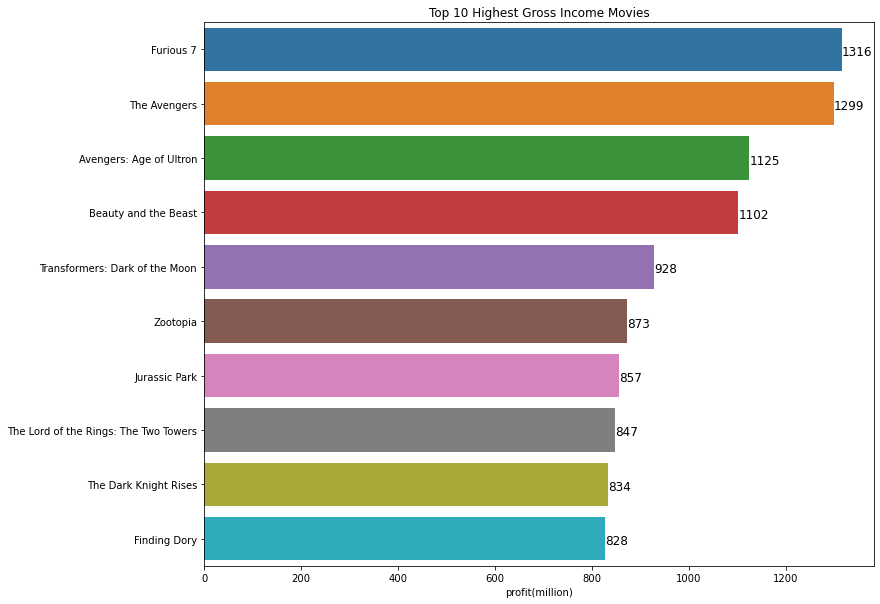

In [43]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(12, 10))
ax = sns.barplot(y='title', x='profit(million)', data=highest_profit, order=highest_profit.sort_values('profit(million)', ascending=False).title, orient='h')
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_width())), (p.get_width(), p.get_y()+0.5), fontsize=12)
plt.title('Top 10 Highest Gross Income Movies', fontsize=12)
plt.ylabel('')
plt.show()

## Genre

In [44]:
# 
# --------------------------------------------------------------------------------
data_explore_encode = data_explore['genres'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')
data_explore_genres = pd.concat([data_explore, data_explore_encode], axis=1)
genres = data_explore_encode.columns
data_explore_genres.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,popularity2,rating,totalVotes,sequel,release_year,release_month,release_day,release_dayofweek,num_of_keywords,all_keywords,keyword_woman director,keyword_independent film,keyword_duringcreditsstinger,keyword_murder,keyword_based on novel,keyword_violence,keyword_sport,keyword_biography,keyword_aftercreditsstinger,keyword_dystopia,num_of_languages,all_languages,language_English,language_Français,language_Español,language_Deutsch,language_Pусский,Comedy,Drama,Family,Romance,Thriller,Action,Animation,Adventure,Horror,Documentary,Music,Crime,Science Fiction,Mystery,Foreign,Fantasy,War,Western,History,TV Movie
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,[Comedy],,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],2/20/2015,93.0,[English],Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke]",[Steve Pink],12314651,10.400,5.0,482.0,1,2015,2,20,4,4,duringcreditsstinger hot tub sequel time travel,0,0,1,0,0,0,0,0,0,0,1,English,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[Comedy, Drama, Family, Romance]",,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,[Walt Disney Pictures],[United States of America],8/6/2004,113.0,[English],Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizondo]",[Garry Marshall],95149435,15.229,6.4,1528.0,1,2004,8,6,4,4,coronation duty falling in love marriage,0,0,0,0,0,0,0,0,0,0,1,English,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# 
# --------------------------------------------------------------------------------
genres_info = []
for col in genres:
    total_movies, total_budget, median_budget, total_revenue, median_revenue, median_popularity, median_popularity2, median_rating, median_totalVotes =0, 0, 0, 0, 0, 0, 0, 0, 0
    total_movies = data_explore_genres[data_explore_genres[col]==1][col].count()
    total_budget = data_explore_genres[data_explore_genres[col]==1]['budget'].sum()
    median_budget = data_explore_genres[data_explore_genres[col]==1]['budget'].median()
    total_revenue = data_explore_genres[data_explore_genres[col]==1]['revenue'].sum()
    median_revenue = data_explore_genres[data_explore_genres[col]==1]['revenue'].median()
    median_popularity = data_explore_genres[data_explore_genres[col]==1]['popularity'].median()
    median_popularity2 = data_explore_genres[data_explore_genres[col]==1]['popularity2'].median()
    median_rating = data_explore_genres[data_explore_genres[col]==1]['rating'].median()
    median_totalVotes = data_explore_genres[data_explore_genres[col]==1]['totalVotes'].median()
    genres_info.append([col, total_movies, total_budget, median_budget, total_revenue, median_revenue, median_popularity,median_popularity2, median_rating, median_totalVotes])

In [46]:
# 
# --------------------------------------------------------------------------------
genres_info = pd.DataFrame(genres_info, columns=['genres', 'movies_count', 'total_budget', 'median_budget', 'total_revenue', 'median_revenue', 'median_popularity','median_popularity2', 'median_rating', 'median_totalVotes'])
genres_info['total_budget(million)'] = genres_info['total_budget'].apply(lambda x : x//1000000)    # budget in millions
genres_info['median_budget(million)'] = genres_info['median_budget'].apply(lambda x : x//1000000)    # budget in millions
genres_info['total_revenue(million)'] = genres_info['total_revenue'].apply(lambda x : x//1000000)    # revenue in millions
genres_info['median_revenue(million)'] = genres_info['median_revenue'].apply(lambda x : x//1000000)    # revenue in millions
genres_info[['genres', 'movies_count', 'total_budget(million)', 'median_budget(million)', 'total_revenue(million)', 'median_revenue(million)', 'median_popularity','median_popularity2', 'median_rating', 'median_totalVotes']]
genre_summary = genres_info.reset_index()

,genres,movies_count,total_budget(million),median_budget(million),total_revenue(million),median_revenue(million),median_popularity,median_popularity2,median_rating,median_totalVotes
0,Comedy,1028,19614,8.0,62580,18.0,6.905488,7.0315,6.1,232.5
1,Drama,1531,25733,6.0,69516,11.0,6.793972,6.8820,6.6,206.0
2,Family,260,11048,24.0,36113,57.0,8.416440,7.8890,6.2,456.0
3,Romance,571,8944,5.0,30094,14.0,6.370105,6.5220,6.4,155.0
4,Thriller,789,20873,13.0,53917,21.0,8.371005,8.4160,6.2,425.0
5,Action,741,29934,20.0,82283,36.0,8.345985,8.3780,6.2,396.0
6,Animation,141,5967,23.0,20830,36.0,9.409701,8.5690,6.6,491.0
7,Adventure,439,23738,28.0,77180,59.0,9.961184,9.0370,6.3,600.0
8,Horror,301,4578,6.0,15865,17.0,8.122042,8.3110,5.9,330.0
9,Documentary,87,76,0.0,403,0.0,1.949044,2.4890,6.9,31.0


## Total count of Movies per Genre

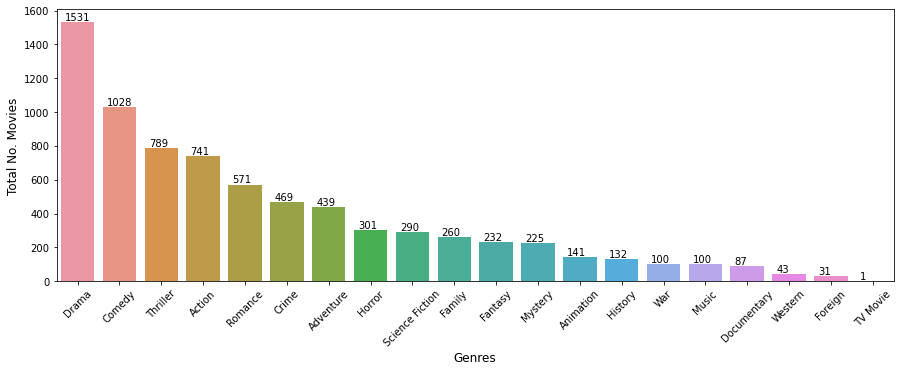

In [48]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='movies_count', data=genres_info, order=genres_info.sort_values('movies_count', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.1, p.get_height()+10))
plt.xticks(rotation=45)
plt.ylabel('Total No. Movies', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

## Median Popularity per Genre

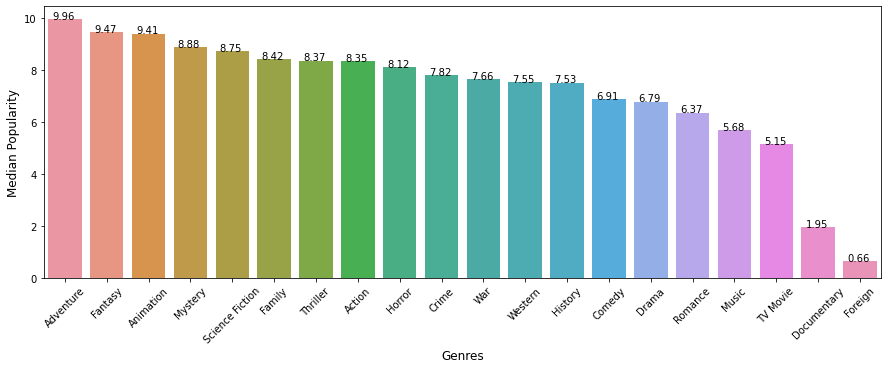

In [49]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='median_popularity', data=genres_info, order=genres_info.sort_values('median_popularity', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(np.round(p.get_height(), 2)), (p.get_x()+0.1, p.get_height()))
plt.xticks(rotation=45)
plt.ylabel('Median Popularity', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

## Median Rating per Genre

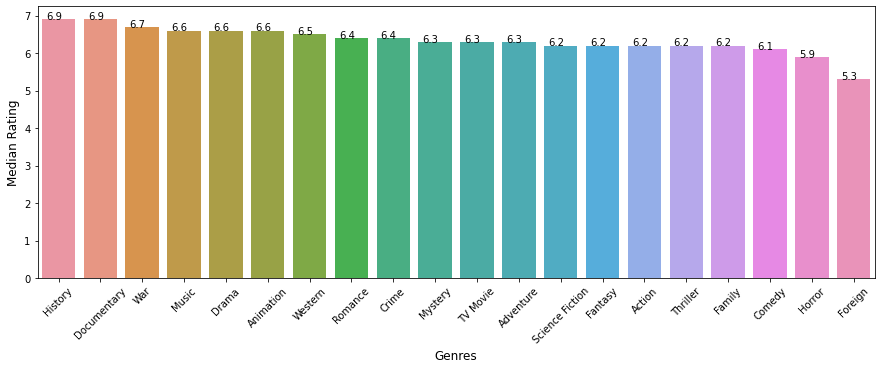

In [50]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='median_rating', data=genres_info, order=genres_info.sort_values('median_rating', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(np.round(p.get_height(), 2)), (p.get_x()+0.1, p.get_height()))
plt.xticks(rotation=45)
plt.ylabel('Median Rating', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

## Median Votes per Genre

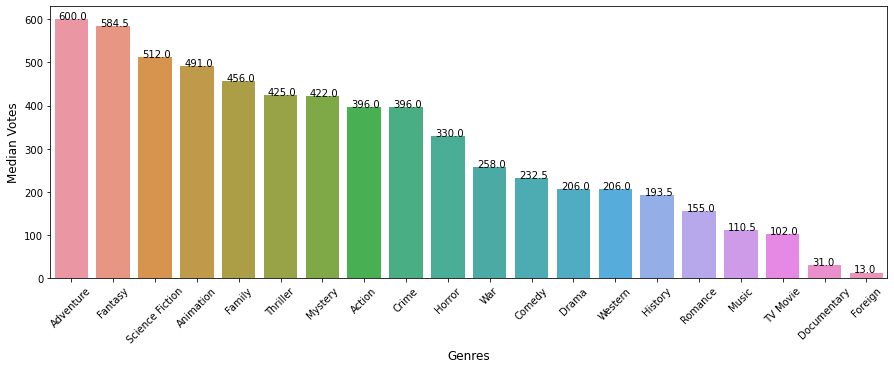

In [51]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='genres', y='median_totalVotes', data=genres_info, order=genres_info.sort_values('median_totalVotes', ascending=False).genres)
for p in ax.patches:
        ax.annotate('{}'.format(np.round(p.get_height(), 2)), (p.get_x()+0.1, p.get_height()))
plt.xticks(rotation=45)
plt.ylabel('Median Votes', fontsize=12)
plt.xlabel('Genres', fontsize=12)
plt.show()

## Median Movie Revenue v Budget per Genre

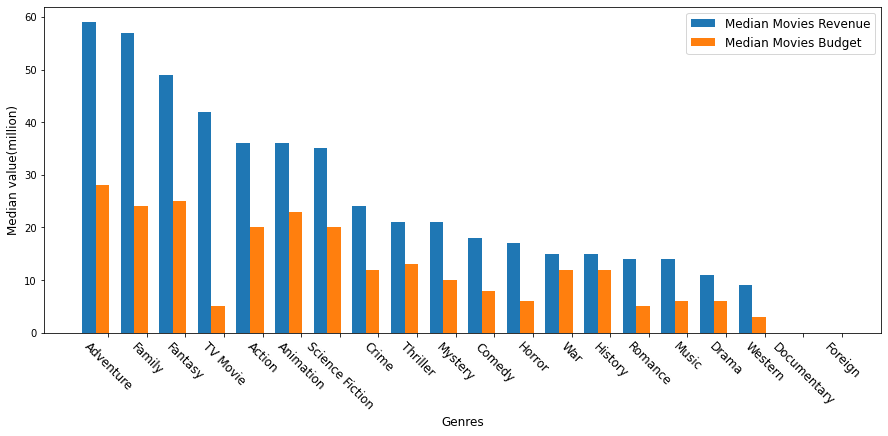

In [52]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 6))
x_indexes = np.arange(len(genres))     
width = 0.35                            
genres_info = genres_info.sort_values('median_revenue(million)', ascending=False)
plt.bar(x_indexes,  genres_info['median_revenue(million)'], label="Median Movies Revenue", width=width)
plt.bar(x_indexes + width,  genres_info['median_budget(million)'], label="Median Movies Budget", width=width)
plt.legend(loc="upper right", fontsize=12)
plt.xticks(ticks=x_indexes+0.5, labels=genres_info['genres'].values, fontsize=12, rotation=-45)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Median value(million)', fontsize=12)
plt.show()

## Average Revenue Per Year

(31.5, 89.5)

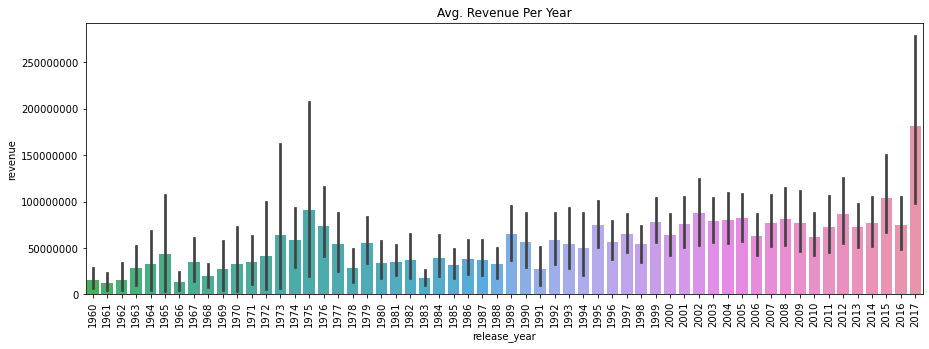

In [53]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
sns.barplot(x='release_year', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue Per Year')
ax.set_xlim(left=31.5)

## Average Revenue Per Month

Text(0.5, 1.0, 'Avg. Revenue Per Month')

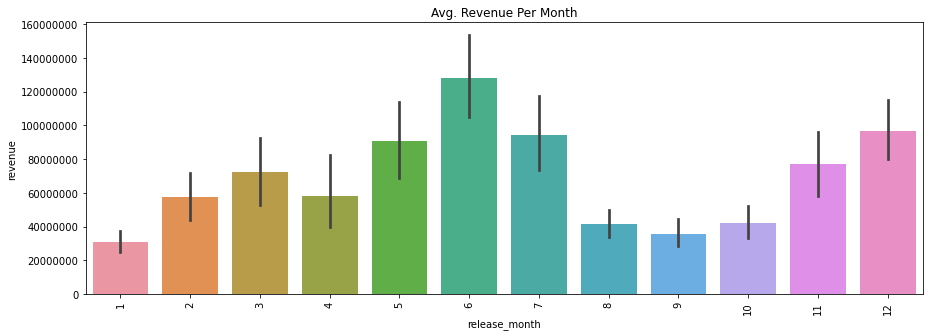

In [54]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
sns.barplot(x='release_month', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue Per Month')

## Average Revenue Per Day of the Week

Text(0.5, 1.0, 'Avg. Revenue for Each Day of Week')

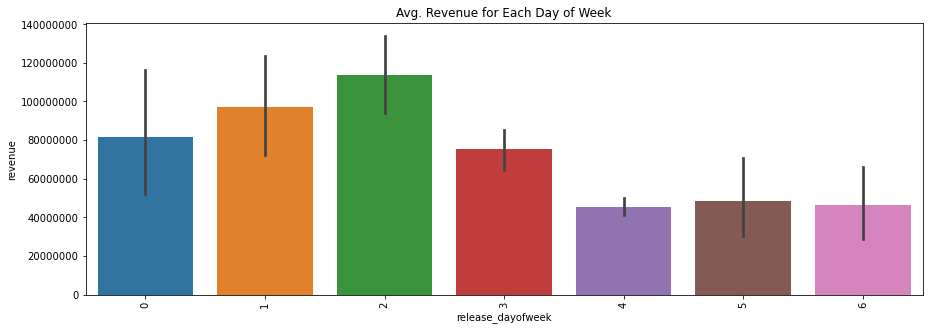

In [55]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
sns.barplot(x='release_dayofweek', y='revenue', data=data_explore, estimator=np.mean)
plt.xticks(rotation=90)
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_title('Avg. Revenue for Each Day of Week')

## Corelation Plot

In [56]:
# 
# --------------------------------------------------------------------------------
data_explore.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes', 'sequel', 'release_year',
       'release_month', 'release_day', 'release_dayofweek', 'num_of_keywords',
       'all_keywords', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_murder',
       'keyword_based on novel', 'keyword_violence', 'keyword_sport',
       'keyword_biography', 'keyword_aftercreditsstinger', 'keyword_dystopia',
       'num_of_languages', 'all_languages', 'language_English',
       'language_Français', 'language_Español', 'language_Deutsch',
       'language_Pусский'],
      dtype='object')

In [57]:
# 
# --------------------------------------------------------------------------------
corr_df = data_explore[['imdb_id','title','genres','popularity','popularity2',
                        'production_companies','production_countries','status','cast', 'crew', 'budget','revenue',
                         'rating', 'totalVotes', 'sequel', 'release_year','runtime','num_of_keywords','num_of_languages']]

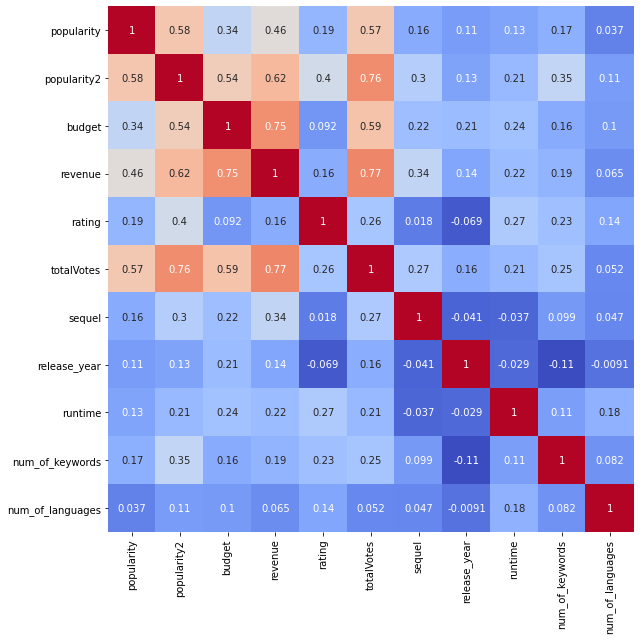

In [58]:
# 
# --------------------------------------------------------------------------------
plt.figure(figsize=(15, 9))
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), square=True, annot=True, cbar=False,cmap='coolwarm')
plt.tight_layout()

In [59]:
# 
# --------------------------------------------------------------------------------
corr_matrix['revenue'].sort_values(ascending=False)

revenue             1.000000
totalVotes          0.774167
budget              0.752965
popularity2         0.624727
popularity          0.461460
sequel              0.339425
runtime             0.216417
num_of_keywords     0.187721
rating              0.159692
release_year        0.137933
num_of_languages    0.064961
Name: revenue, dtype: float64

## Saving to CSV

In [60]:
# 
# --------------------------------------------------------------------------------
data_explore.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes', 'sequel', 'release_year',
       'release_month', 'release_day', 'release_dayofweek', 'num_of_keywords',
       'all_keywords', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_murder',
       'keyword_based on novel', 'keyword_violence', 'keyword_sport',
       'keyword_biography', 'keyword_aftercreditsstinger', 'keyword_dystopia',
       'num_of_languages', 'all_languages', 'language_English',
       'language_Français', 'language_Español', 'language_Deutsch',
       'language_Pусский'],
      dtype='object')

In [61]:
# 
# --------------------------------------------------------------------------------
data_explore_genres.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'popularity2', 'rating', 'totalVotes', 'sequel', 'release_year',
       'release_month', 'release_day', 'release_dayofweek', 'num_of_keywords',
       'all_keywords', 'keyword_woman director', 'keyword_independent film',
       'keyword_duringcreditsstinger', 'keyword_murder',
       'keyword_based on novel', 'keyword_violence', 'keyword_sport',
       'keyword_biography', 'keyword_aftercreditsstinger', 'keyword_dystopia',
       'num_of_languages', 'all_languages', 'language_English',
       'language_Français', 'language_Español', 'language_Deutsch',
       'language_Pусский', 'Comedy', 'Drama', 'Family', 'Romance', 'Thriller',
  

In [62]:
# 
# --------------------------------------------------------------------------------
data_explore_genres.to_csv("../Resources/data/model_data.csv",index=False)

In [63]:
# 
# --------------------------------------------------------------------------------
database_html = data_explore[['id','imdb_id','belongs_to_collection','poster_path','original_title','title','genres', 'status',
                              'release_date','release_year','runtime','cast', 'crew','overview','spoken_languages',
                              'popularity2', 'rating', 'totalVotes','budget','revenue']]
database_html.to_csv("../Resources/data/database_html.csv",index=False)                      

In [67]:
genre_summary.to_csv("../Resources/data/databaseGenre_html.csv",index=False)